In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis
from libs import helpers
from libs.metrics import aggregators
from libs.metrics import helpers as helpers_metrics
from libs.visuals import polar_infra
from libs import latex

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


# Setup

In [3]:
APS_OA_DATA_TAR_GZ = '../../../APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/interventions/metadata/disciplines_author_demographics.csv'


In [4]:
SUMMARY_PATH = '../../results/interventions/summaries'
VALID_RESPONSES_PATH = '../../results/interventions/valid_responses'
FACTUALITY_PATH = '../../results/interventions/factuality'
PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

In [5]:
vis.sns_reset()
vis.sns_paper_style(font_scale=1.55)

## Data

In [ ]:
# Load the summary data for each model (all outputs)
df_summary_all = io.pd.concat([io.read_csv(io.path_join(SUMMARY_PATH, f"experiments_{model}.csv"), low_memory=False) for model in constants.LLMS], ignore_index=True)
df_valid_responses_all = io.pd.concat([io.read_csv(io.path_join(VALID_RESPONSES_PATH, f"{model}.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_author_all = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_author.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_field_all = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_field.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_seniority_all = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_seniority.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)
df_factuality_epoch_all = io.pd.concat([io.read_csv(io.path_join(FACTUALITY_PATH, f"{model}_epoch.csv"), index_col=0, low_memory=False) for model in constants.LLMS], ignore_index=True)

df_summary_all.shape, df_valid_responses_all.shape, df_factuality_author_all.shape, df_factuality_field_all.shape, df_factuality_seniority_all.shape, df_factuality_epoch_all.shape
# (72117, 20)

In [ ]:
# filter period (valid for open-weight models)
# 2026-01-15 some models were not available (eg. gemma, qwen)
start_date = '2025-12-19'
end_date = '2026-01-18'

# filter out interventions
query = "((not model.str.contains('gemini') and date >= @start_date and date <= @end_date) or model.str.contains('gemini'))"

df_summary = df_summary_all.query(query).copy()
df_valid_responses = df_valid_responses_all.query(query).copy()
df_factuality_author = df_factuality_author_all.query(query).copy()
df_factuality_field = df_factuality_field_all.query(query).copy()
df_factuality_seniority = df_factuality_seniority_all.query(query).copy()
df_factuality_epoch = df_factuality_epoch_all.query(query).copy()

# shapes
df_summary.shape, df_valid_responses.shape, df_factuality_author.shape, df_factuality_field.shape, df_factuality_seniority.shape, df_factuality_epoch.shape


In [32]:
# demographics
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# scholarly stats
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# per discipline
df_gt_stats = io.read_csv(APS_OS_DISCIPLINE_DEMOGRAPHICS, index_col=0, header=[0, 1])

# gt (from APS)
df_gt = df_all_authors_demographics[['id_author_oa','first_name','last_name','ethnicity','gender']].copy()
df_gt = df_gt.merge(df_all_authors_stats[['id_author_oa','works_count','cited_by_count', 'rr1_rank_publications','rr1_rank_publications_percentile', 'rr2_rank_citations','rr2_rank_citations_percentile']], on='id_author_oa', how='left')
df_gt = helpers.add_quantiles(df_gt)

# shapes
df_all_authors_demographics.shape, df_gt_stats.shape, df_gt_stats.shape, df_gt.shape

((481012, 14), (17, 19), (17, 19), (481012, 13))

In [35]:
df_gt.gender.value_counts(normalize=True) * 100

gender
Male       44.432779
Unknown    42.221192
Female      8.772130
Unisex      4.573898
Name: proportion, dtype: float64

## Augmenting data

In [ ]:
# adding prominence metrics to recommended authors
df_factuality_author = df_factuality_author.merge(df_gt[['id_author_oa', 'prominence_pub', 'prominence_cit']], on='id_author_oa', how='left')

# adding infrastructure metadata
df_summary = helpers.add_infrastructure_columns(df_summary)
df_factuality_author = helpers.add_infrastructure_columns(df_factuality_author)

# shapes
df_summary.shape, df_factuality_author.shape


# Metrics

In [ ]:
# computes the metric per attempt for ALL requests

_ = helpers_metrics.load_per_attempt('validity_pct', df_summary, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('factuality_author', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('duplicates', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('refusal_pct', df_summary, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('consistency', df_factuality_author, TABLES_PATH)

_ = helpers_metrics.load_per_attempt('diversity_gender', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('diversity_ethnicity', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('diversity_prominence_pub', df_factuality_author, TABLES_PATH)
_ = helpers_metrics.load_per_attempt('diversity_prominence_cit', df_factuality_author, TABLES_PATH)

_ = helpers_metrics.load_per_attempt('parity_gender', df_factuality_author, TABLES_PATH, gt=df_gt)
_ = helpers_metrics.load_per_attempt('parity_ethnicity', df_factuality_author, TABLES_PATH, gt=df_gt)
_ = helpers_metrics.load_per_attempt('parity_prominence_pub', df_factuality_author, TABLES_PATH, gt=df_gt)
_ = helpers_metrics.load_per_attempt('parity_prominence_cit', df_factuality_author, TABLES_PATH, gt=df_gt)

# @TODO: add diveristy country 

# @TODO: add a metric for coauthorship among recommended authors

# Plots

In [6]:
# filter out interventions
query_infra = "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"

In [7]:
FIGSIZE = (10, 2.)
FIGSIZE_TOP = (10, 2.15)
PLOT_KWARGS = {'figsize':FIGSIZE, 'ylim':(0, 1), 'show_xticks':True}
PLOT_KWARGS_D = {'figsize':FIGSIZE, 'ylim':(0, 0.06), 'show_xticks':True}
PLOT_KWARGS_M = {'figsize':FIGSIZE, 'ylim':(0, 0.5), 'show_xticks':True}
PLOT_KWARGS_H = {'figsize':FIGSIZE, 'ylim':(0, 0.2), 'show_xticks':True}
PLOT_KWARGS_TOP = {'figsize':FIGSIZE_TOP, 'ylim':(0, 1), 'show_title':True, 'show_xticks':True}

PREFIX = 'infrastructure'

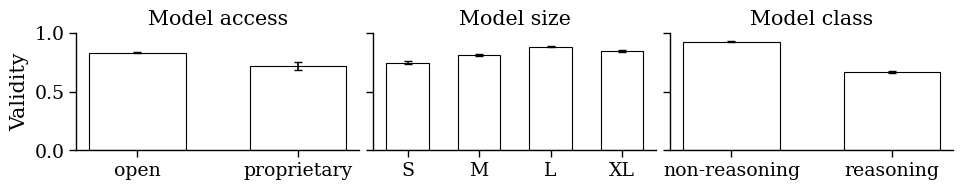

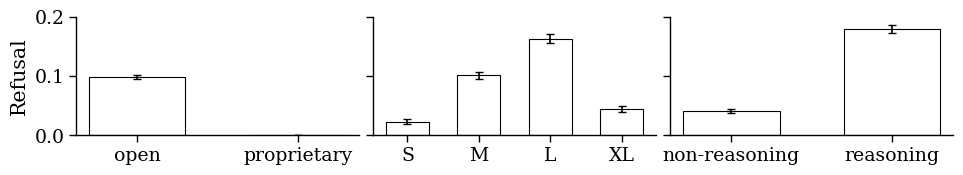

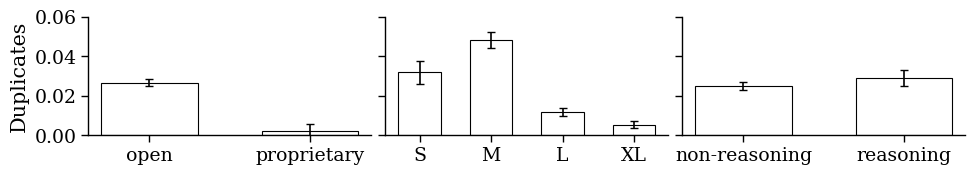

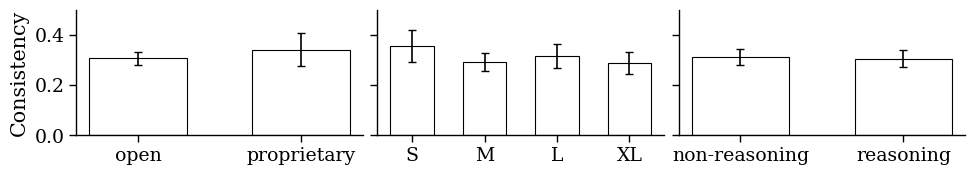

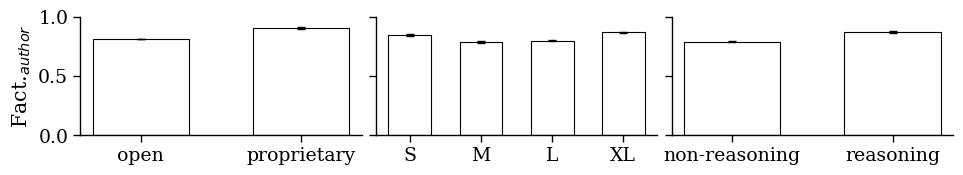

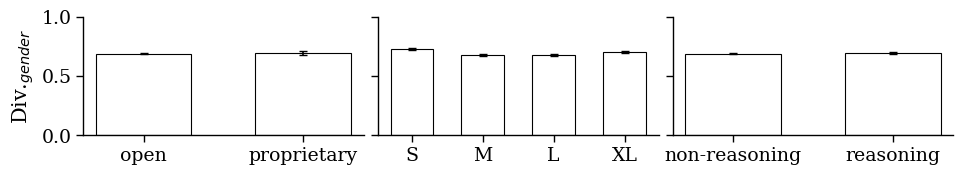

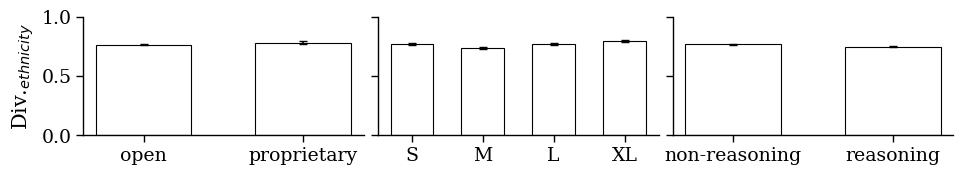

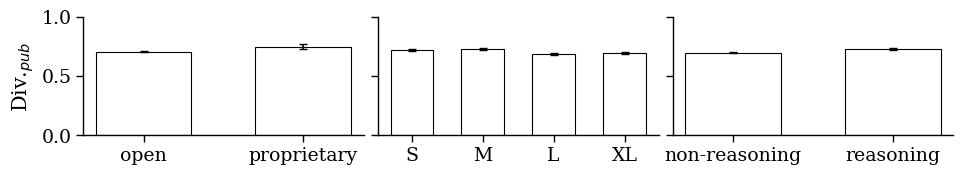

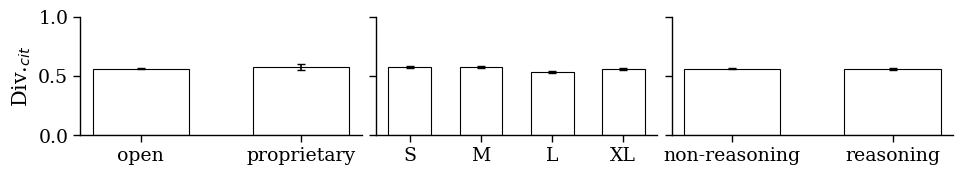

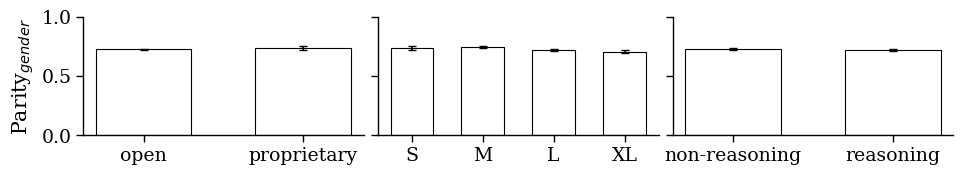

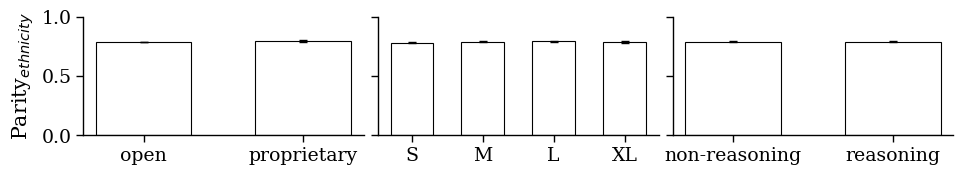

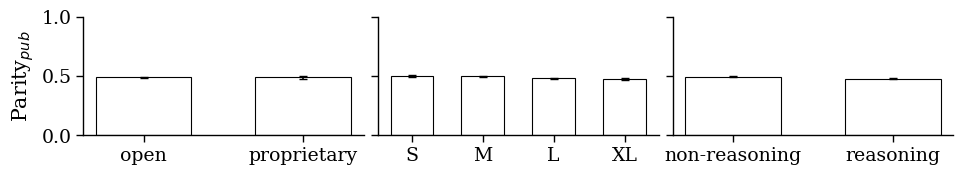

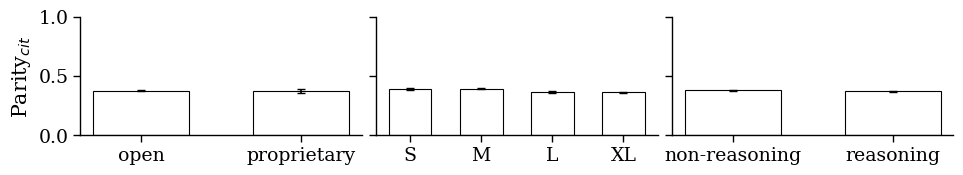

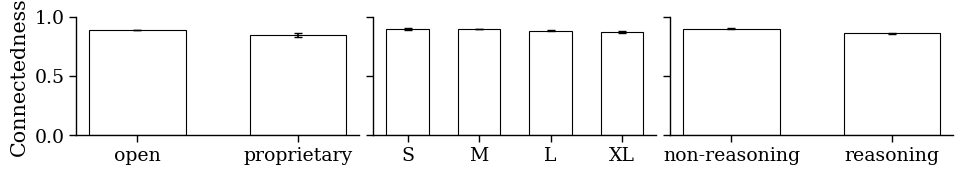

In [10]:
for metric in helpers_metrics.METRICS:
    fn = helpers_metrics.get_plot_fn(metric, PLOTS_PATH, prefix=PREFIX)
    per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query_infra)
    per_attempt = helpers.add_infrastructure_columns(per_attempt)

    kwargs = PLOT_KWARGS_TOP if metric == 'validity_pct' else PLOT_KWARGS_H if metric == 'refusal_pct' else PLOT_KWARGS_D if metric == 'duplicates' else PLOT_KWARGS_M if metric == 'consistency' else PLOT_KWARGS
    vis.plot_infrastructural_conditions(per_attempt, fn=fn, continuous=False, ylabel=metric, **kwargs)


# Summary table

In [11]:
import pandas as pd

fn_attempt = io.path_join(TABLES_PATH, 'infrastructure_per_attempt.csv')
fn_group = io.path_join(TABLES_PATH, 'infrastructure_per_group.csv')

if not io.exists(fn_group) or not io.exists(fn_attempt):

    df_summary_infrastructure_attempt = pd.DataFrame()
    df_summary_infrastructure_group = pd.DataFrame()
    for group in ['model_access', 'model_size', 'model_class']:
        
        for metric in helpers_metrics.METRICS:
            per_attempt = helpers_metrics.load_per_attempt(metric, None, TABLES_PATH).query(query_infra)

            per_attempt.loc[:, 'metric_name'] = metric
            per_attempt.rename(columns={'metric':'metric_value'}, inplace=True)
            df_summary_infrastructure_attempt = pd.concat([df_summary_infrastructure_attempt, per_attempt], axis=0, ignore_index=True)

            per_attempt = helpers.add_infrastructure_columns(per_attempt)
            is_bernoulli = metric in ['validity_pct', 'refusal_pct']
            per_group = aggregators.aggregate_per_group(per_attempt, group, alpha=0.05, is_bernoulli=is_bernoulli, metric_col_name='metric_value')
            per_group.rename(columns={group: 'infrastructure'}, inplace=True)
            per_group.loc[:, 'metric_name'] = metric
            df_summary_infrastructure_group = pd.concat([df_summary_infrastructure_group, per_group], axis=0, ignore_index=True)

    df_summary_infrastructure_attempt.reset_index(drop=True, inplace=True)
    df_summary_infrastructure_attempt.to_csv(fn_attempt)

    df_summary_infrastructure_group.reset_index(drop=True, inplace=True)
    df_summary_infrastructure_group.to_csv(fn_group)

else:
    df_summary_infrastructure_attempt = io.read_csv(fn_attempt)
    df_summary_infrastructure_group = io.read_csv(fn_group)


In [12]:
pt_mean = df_summary_infrastructure_group.pivot_table(index='infrastructure', columns='metric_name', values="mean")
pt_ci = df_summary_infrastructure_group.pivot_table(index='infrastructure', columns='metric_name', values="ci")
pt_low = df_summary_infrastructure_group.pivot_table(index='infrastructure', columns='metric_name', values="ci_low")
pt_high = df_summary_infrastructure_group.pivot_table(index='infrastructure', columns='metric_name', values="ci_high")

df_summary_infrastructure = (
    pt_mean.round(2).astype(str)
    + " $\\pm$ "
    + pt_ci.round(2).astype(str)
    
    # + " [" + pt_low.round(2).astype(str) + ", " + pt_high.round(2).astype(str) + "]"
)

df_summary_infrastructure = df_summary_infrastructure.where(
    pt_mean.notna() & pt_ci.notna(), ""
)

row_order = ['open', 'proprietary', 'S', 'M', 'L', 'XL', 'non-reasoning', 'reasoning']
df_summary_infrastructure = df_summary_infrastructure.reindex(
    index=row_order,
    columns=helpers_metrics.METRICS,
)

df_summary_infrastructure.to_latex(io.path_join(LATEX_PATH, 'infrastructure_summary.tex'))
df_summary_infrastructure


metric_name,validity_pct,refusal_pct,duplicates,consistency,factuality_author,diversity_gender,diversity_ethnicity,diversity_prominence_pub,diversity_prominence_cit,parity_gender,parity_ethnicity,parity_prominence_pub,parity_prominence_cit,connectedness
infrastructure,,,,,,,,,,,,,,
open,0.83 $\pm$ 0.0,0.1 $\pm$ 0.0,0.03 $\pm$ 0.0,0.31 $\pm$ 0.02,0.81 $\pm$ 0.0,0.69 $\pm$ 0.0,0.76 $\pm$ 0.0,0.7 $\pm$ 0.0,0.56 $\pm$ 0.0,0.72 $\pm$ 0.01,0.79 $\pm$ 0.0,0.49 $\pm$ 0.0,0.38 $\pm$ 0.0,0.89 $\pm$ 0.0
proprietary,0.72 $\pm$ 0.03,0.0 $\pm$ 0.0,0.0 $\pm$ 0.0,0.34 $\pm$ 0.07,0.91 $\pm$ 0.01,0.69 $\pm$ 0.02,0.78 $\pm$ 0.02,0.75 $\pm$ 0.02,0.58 $\pm$ 0.02,0.73 $\pm$ 0.02,0.8 $\pm$ 0.01,0.49 $\pm$ 0.01,0.37 $\pm$ 0.02,0.84 $\pm$ 0.02
S,0.75 $\pm$ 0.01,0.02 $\pm$ 0.0,0.03 $\pm$ 0.01,0.36 $\pm$ 0.06,0.84 $\pm$ 0.01,0.73 $\pm$ 0.01,0.77 $\pm$ 0.01,0.72 $\pm$ 0.01,0.58 $\pm$ 0.01,0.73 $\pm$ 0.01,0.78 $\pm$ 0.01,0.5 $\pm$ 0.01,0.39 $\pm$ 0.01,0.9 $\pm$ 0.01
M,0.81 $\pm$ 0.01,0.1 $\pm$ 0.01,0.05 $\pm$ 0.0,0.29 $\pm$ 0.04,0.79 $\pm$ 0.01,0.68 $\pm$ 0.01,0.74 $\pm$ 0.01,0.73 $\pm$ 0.01,0.58 $\pm$ 0.01,0.74 $\pm$ 0.01,0.79 $\pm$ 0.01,0.5 $\pm$ 0.0,0.39 $\pm$ 0.0,0.9 $\pm$ 0.0
L,0.88 $\pm$ 0.01,0.16 $\pm$ 0.01,0.01 $\pm$ 0.0,0.32 $\pm$ 0.05,0.8 $\pm$ 0.01,0.68 $\pm$ 0.01,0.77 $\pm$ 0.01,0.68 $\pm$ 0.01,0.54 $\pm$ 0.01,0.72 $\pm$ 0.01,0.79 $\pm$ 0.01,0.48 $\pm$ 0.0,0.37 $\pm$ 0.01,0.88 $\pm$ 0.0
XL,0.84 $\pm$ 0.01,0.04 $\pm$ 0.01,0.01 $\pm$ 0.0,0.29 $\pm$ 0.04,0.87 $\pm$ 0.01,0.7 $\pm$ 0.01,0.79 $\pm$ 0.01,0.7 $\pm$ 0.01,0.56 $\pm$ 0.01,0.71 $\pm$ 0.01,0.79 $\pm$ 0.01,0.48 $\pm$ 0.01,0.36 $\pm$ 0.01,0.87 $\pm$ 0.01
non-reasoning,0.92 $\pm$ 0.0,0.04 $\pm$ 0.0,0.02 $\pm$ 0.0,0.31 $\pm$ 0.03,0.79 $\pm$ 0.0,0.69 $\pm$ 0.01,0.77 $\pm$ 0.0,0.7 $\pm$ 0.0,0.56 $\pm$ 0.0,0.73 $\pm$ 0.01,0.79 $\pm$ 0.0,0.49 $\pm$ 0.0,0.38 $\pm$ 0.0,0.9 $\pm$ 0.0
reasoning,0.67 $\pm$ 0.01,0.18 $\pm$ 0.01,0.03 $\pm$ 0.0,0.31 $\pm$ 0.03,0.87 $\pm$ 0.0,0.69 $\pm$ 0.01,0.75 $\pm$ 0.01,0.73 $\pm$ 0.01,0.56 $\pm$ 0.01,0.72 $\pm$ 0.01,0.79 $\pm$ 0.0,0.48 $\pm$ 0.0,0.37 $\pm$ 0.0,0.86 $\pm$ 0.0


In [20]:

cols_paper = [c for c in helpers_metrics.METRICS if (('parity' in c or 'diversity' in c) and 'gender' in c) or ('parity' not in c and 'diversity' not in c)]

df_bold = latex.bold_best_within_groups(df_summary_infrastructure[cols_paper], latex.group_map_infrastructure, latex.metric_higher_better, latex.metric_lower_better)

def title_name(x):
    if x == 'S':
        x = 'small'
    if x == 'M':
        x = 'medium'
    if x == 'L':
        x = 'large'
    if x == 'XL':
        x = 'extra large'
    
    if x.isupper():
        return x
    return x.title()

df_bold.index = df_bold.index.map(title_name)

latex_str = df_bold.to_latex(
    escape=False,          # IMPORTANT: keep \textbf and your $\pm$
    index=True,
    column_format="l" + "c"*len(df_bold.columns),
)
print(latex_str)


\begin{tabular}{lcccccccc}
\toprule
metric_name & validity_pct & refusal_pct & duplicates & consistency & factuality_author & connectedness & diversity_gender & parity_gender \\
infrastructure &  &  &  &  &  &  &  &  \\
\midrule
Open & \textbf{0.83 $\pm$ 0.0}  & 0.1 $\pm$ 0.0 & 0.03 $\pm$ 0.0 & 0.31 $\pm$ 0.02 & 0.81 $\pm$ 0.0 & 0.89 $\pm$ 0.0 & 0.69 $\pm$ 0.0 & 0.72 $\pm$ 0.01 \\
Proprietary & 0.72 $\pm$ 0.03 & 0.0 $\pm$ 0.0 & \textbf{0.0 $\pm$ 0.0}  & 0.34 $\pm$ 0.07 & \textbf{0.91 $\pm$ 0.01}  & 0.84 $\pm$ 0.02 & 0.69 $\pm$ 0.02 & \textbf{0.73 $\pm$ 0.02}  \\
Small & 0.75 $\pm$ 0.01 & 0.02 $\pm$ 0.0 & 0.03 $\pm$ 0.01 & 0.36 $\pm$ 0.06 & 0.84 $\pm$ 0.01 & 0.9 $\pm$ 0.01 & 0.73 $\pm$ 0.01 & 0.73 $\pm$ 0.01 \\
Medium & 0.81 $\pm$ 0.01 & 0.1 $\pm$ 0.01 & 0.05 $\pm$ 0.0 & 0.29 $\pm$ 0.04 & 0.79 $\pm$ 0.01 & 0.9 $\pm$ 0.0 & 0.68 $\pm$ 0.01 & \textbf{0.74 $\pm$ 0.01}  \\
Large & \textbf{0.88 $\pm$ 0.01}  & 0.16 $\pm$ 0.01 & \textbf{0.01 $\pm$ 0.0}  & 0.32 $\pm$ 0.05 & 0.8 $\pm$ 0.01 & 0.88

/code/espinl/LLMScholar-Audits/Auditor/notebooks/benchmak_interventions/../../code/libs/latex.py:33: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  num = out.applymap(extract_mean)


## Overal performance per model

In [14]:
cols_group = ['model', 'grounded', 'temperature', 'task_name', 'task_param', 'metric_name']
per_attempt_data = df_summary_infrastructure_attempt.groupby(cols_group)['metric_value'].agg(['mean', 'std']).reset_index()
per_attempt_data = per_attempt_data.fillna(value={'std':0}).dropna(subset=['mean'])

per_attempt_data.loc[:, 'metric_group'] = per_attempt_data.metric_name.apply(lambda x: x.split('_')[0])
per_attempt_data.loc[:, 'metric_name'] = per_attempt_data.metric_name.apply(lambda x: x.split('_')[-1] if len(x.split('_')) > 1 else x)

per_attempt_data.head(2)


,model,grounded,temperature,task_name,task_param,metric_name,mean,std,metric_group
0,deepseek-chat-v3.1,False,0.0,epoch,1950s,connectedness,0.931071,0.038189,connectedness
1,deepseek-chat-v3.1,False,0.0,epoch,1950s,consistency,0.485875,0.000000,consistency


In [15]:
# models' metadata
df_models_metadata = pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'propietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'R' if x else 'NR')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.loc[0, 'model_name'] = 'llama-3.3-8b'
df_models_metadata.head(2)


,model,max_attempts,temperature,max_temperature,stop,stream,system_message_ref,provider,sub_provider,quantization,...,input_price,output_price,reasoning,class,class1,grounded,model_name,model_access,model_size,model_class
0,meta-llama/llama-3.1-8b-instruct,3,0.0,2,NaN,False,physics_research_assistant,openrouter,deepinfra/bf16,fp16,...,0.03,0.05,False,S,NaN,NaN,llama-3.3-8b,open,S,NR
1,meta-llama/llama-4-scout,3,1.0,2,NaN,False,physics_research_assistant,openrouter,deepinfra/fp8,fp8,...,0.08,0.30,False,L,NaN,NaN,llama-4-scout,open,L,NR


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


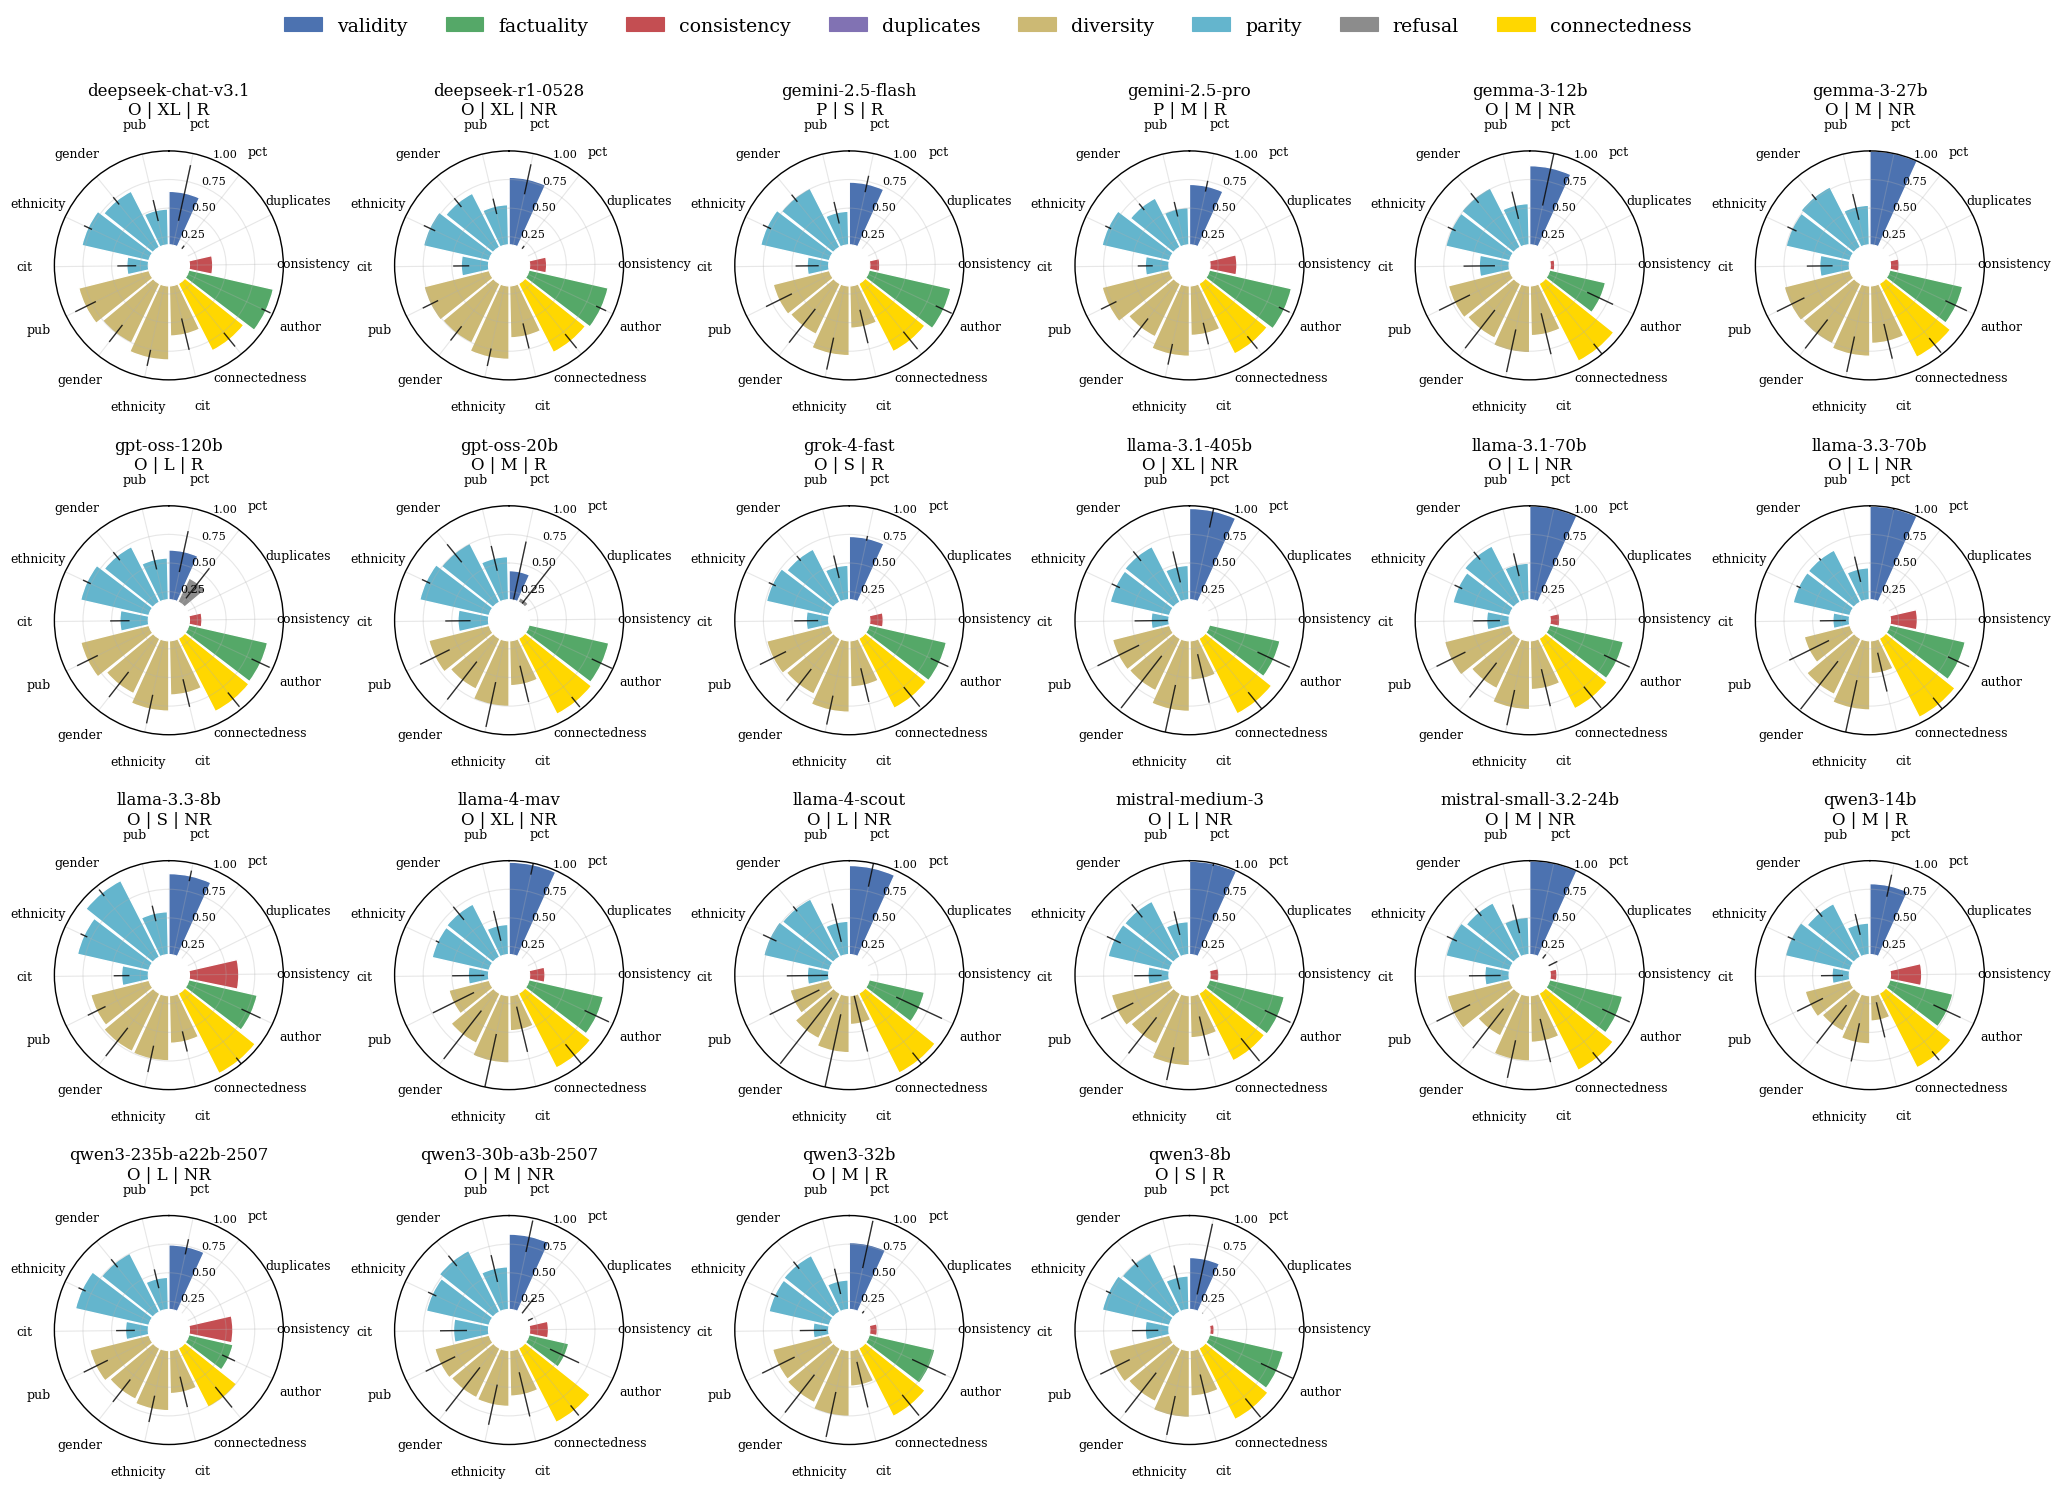

In [18]:
df_metrics = per_attempt_data.copy()

# order axis by metric
order = ["validity", "refusal", "duplicates", "consistency", "factuality",'connectedness', "diversity", "parity"]

# Define colors by metric_group (edit to match your groups exactly)
group_colors = {
            "validity": "#4C72B0",
            "factuality": "#55A868",
            "consistency": "#C44E52",
            "duplicates": "#8172B3",
            "diversity": "#CCB974",
            "parity": "#64B5CD",
            "refusal": "#8C8C8C",
            'connectedness': '#FFD700'
        }

fig = polar_infra.plot_model_grid(
    df_metrics=df_metrics,
    df_meta=df_models_metadata,
    meta_cols={"model": "model_name", "access": "model_access", "size": "model_size", "class": "model_class"},
    ncols=6,
    order=order,               # or your explicit list
    group_colors=group_colors,
    figsize_per_cell=(4.2, 4.2),
)

fig.savefig(io.path_join(PLOTS_PATH, 'infrastructure_by_model.pdf'), dpi=300, bbox_inches='tight')

polar_infra.plt.show()
polar_infra.plt.close()
